In [240]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import curve_fit
import scipy.constants as c
from scipy import stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, hstack, vstack
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [197]:
I_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)

I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012


In [198]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

In [199]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [200]:
daofind = DAOStarFinder(fwhm=3.0, threshold=3.5*backgr_std)

mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
mask[1600:1700, 1250:1350] = False
mask[1100:1200, 1500:1600] = False
mask[1300:1500, 1200:1400] = False
sources_compar = daofind(linpol_intens_freqmean - backgr_median, mask=mask)
for col in sources_compar.colnames:
    sources_compar[col].info.format = '%.8g'  # for consistent table output
print(sources_compar)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag    
--- --------- --------- ---------- ... --- ------------- --------- -----------
  1 1574.1474 1124.9486 0.39922598 ...   0 0.00090003421 9.9840803  -2.4982702
  2 1564.6967 1137.2616 0.40011825 ...   0 0.00017359151 1.9636412 -0.73265533
  3 1560.8153 1141.9812 0.39641346 ...   0 0.00036038106 3.8264251   -1.456983
  4  1356.121 1404.4902 0.39600383 ...   0 0.00010838422 1.1268673 -0.12968196
  5 1290.9782 1658.5458 0.39955294 ...   0  0.0015098529 16.715295  -3.0577851


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'SPECLNMF'  'STOKES'  
CRVAL : 10.45282638889222  -9.317925555555556  1283791015.625  1.0  
CRPIX : 1809.0  1809.0  1.0  1.0  
NAXIS : 3617  3617  12  1


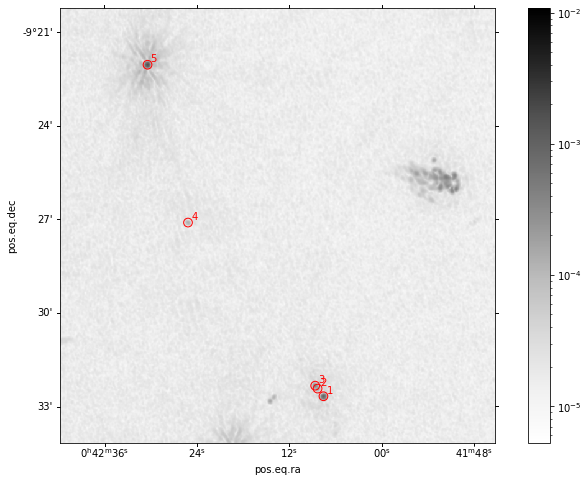

In [201]:
from photutils.aperture import CircularAperture
positions_compar = np.transpose((sources_compar['xcentroid'], sources_compar['ycentroid']))
apertures_compar = CircularAperture(positions_compar, r=7.)

plt.figure(figsize=(12,8))
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
plt.ylim(1050,1750)
plt.xlim(1150,1850)
apertures_compar.plot(color='red', lw=1)
for n in range(5):
    plt.text(sources_compar['xcentroid'][n]+5, sources_compar['ycentroid'][n]+5, sources_compar['id'][n], color='red')
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=300)

print(I_wcs)
#print(apertures_compar.to_sky(I_wcs))

In [202]:
#annulus_apertures_compar = CircularAnnulus(positions_compar, r_in=8., r_out=13.)
#apers_compar = [apertures_compar, annulus_apertures_compar]
FWHM_major_axis = 2.140979E-03*c.degree
FWHM_minor_axis = 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
print(FWHM_major_axis)

def photometry(data_local, apers_local):
    data_local_intensity = data_local*4*np.log(2)/(np.pi*FWHM_major_axis*FWHM_minor_axis)
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    phot_mean = phot_table['aperture_sum']/apers_local.area
    flux = phot_mean*apers_local.area*(pixsize**2)
    phot_table['flux'] = flux
    return(phot_table)

phot_table_compar = photometry(linpol_intens_freqmean, apertures_compar)
print(apertures_compar[0].area)
print(phot_table_compar)

3.7367132766055673e-05
153.93804002589985
 id      xcenter       ...    aperture_sum             flux         
           pix         ...                                          
--- ------------------ ... ------------------ ----------------------
  1 1574.1473878079303 ...  28431329.22645449  0.0009533349138974699
  2 1564.6966903277728 ... 11389089.851494972 0.00038188917959005675
  3  1560.815257203651 ... 14192657.428782342 0.00047589599979922556
  4 1356.1209625517888 ...  5168987.520831427 0.00017332205025869063
  5 1290.9782154774423 ...  46705818.85035536    0.00156609940525693


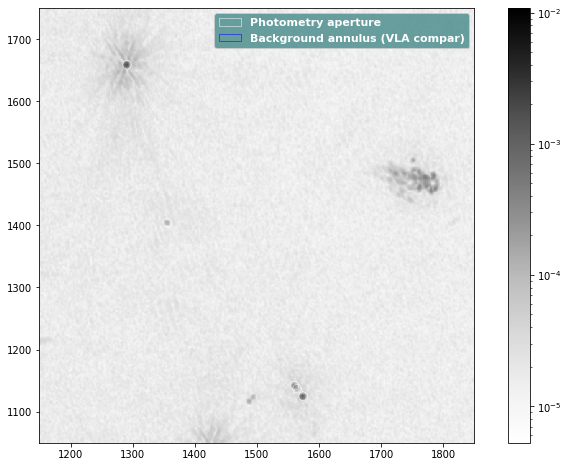

In [203]:
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()

ap_patches_compar = apertures_compar.plot(color='white', lw=0.5, label='Photometry aperture')
#ann_patches_compar = annulus_apertures_compar.plot(color='blue', lw=0.5, label='Background annulus (VLA compar)')
#handles_compar = (ap_patches_compar[0], ann_patches_compar[0])
#plt.legend(facecolor='#458989', labelcolor='white', handles=ap_patches_compar[0], prop={'weight': 'bold', 'size': 11})
plt.ylim(1050,1750)
plt.xlim(1150,1850)
plt.savefig('ACO85_Linpol_Photometry.pdf', dpi=300)

In [204]:
I_phot_table_compar = np.zeros((12, len(sources_compar)))
Q_phot_table_compar = np.zeros((12, len(sources_compar)))
U_phot_table_compar = np.zeros((12, len(sources_compar)))
V_phot_table_compar = np.zeros((12, len(sources_compar)))

for n in range(12):
    I_slice_phot_compar = photometry(I_cube[n], apertures_compar)
    Q_slice_phot_compar = photometry(Q_cube[n], apertures_compar)
    U_slice_phot_compar = photometry(U_cube[n], apertures_compar)
    V_slice_phot_compar = photometry(V_cube[n], apertures_compar)
    for i in range(len(sources_compar)):
        I_phot_table_compar[n, i] = I_slice_phot_compar[i]['flux']
        Q_phot_table_compar[n, i] = Q_slice_phot_compar[i]['flux']
        U_phot_table_compar[n, i] = U_slice_phot_compar[i]['flux']
        V_phot_table_compar[n, i] = V_slice_phot_compar[i]['flux']
print(np.shape(I_phot_table_compar))

(12, 5)


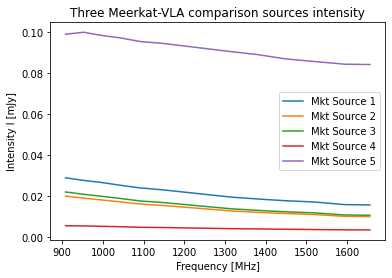

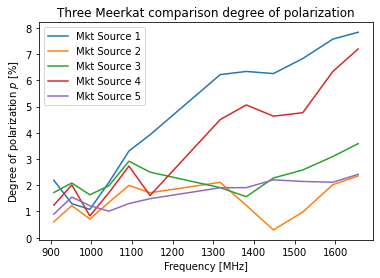

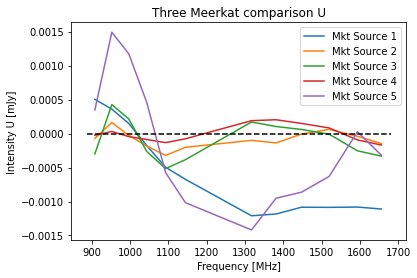

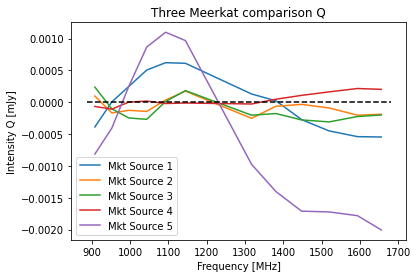

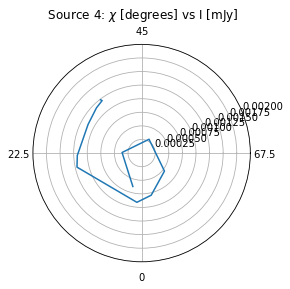

In [227]:
Pol_Angles_compar = 0.5*np.arctan(U_phot_table_compar/Q_phot_table_compar)
Linpol_compar = np.sqrt(U_phot_table_compar**2 + Q_phot_table_compar**2)

Labels = ['Mkt Source 1', 'Mkt Source 2', 'Mkt Source 3', 'Mkt Source 4', 'Mkt Source 5']
plt.title('Three Meerkat-VLA comparison sources intensity')
plt.plot(freqs_middle/1e6, I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison degree of polarization')
plt.plot(freqs_middle/1e6, 100*Linpol_compar/I_phot_table_compar, label=Labels)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison U')
plt.plot(freqs_middle/1e6, U_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison Q')
plt.plot(freqs_middle/1e6, Q_phot_table_compar, label=Labels)
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_compar[:,0], Linpol_compar[:,0])
ax.set_rmax(0.002)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 4: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [211]:
Freqs_VLA = np.loadtxt(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\lambda_squared.txt', dtype=float)[:,1]*1e9

I_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA = np.zeros((len(Freqs_VLA),5))

fname_pt1 = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data\Abell_85_photometry\Stokes_'
fname_pt2 = r'\Stokes'
fname_pt3 = r'cor_source_'

for n in range(5):
    I_phot_table_VLA[:,n] = np.load(fname_pt1+'I'+fname_pt2+'I'+fname_pt3+str(n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA[:,n] = np.load(fname_pt1+'Q'+fname_pt2+'Q'+fname_pt3+str(n)+'.npy', allow_pickle=True)
    U_phot_table_VLA[:,n] = np.load(fname_pt1+'U'+fname_pt2+'U'+fname_pt3+str(n)+'.npy', allow_pickle=True)
print(np.shape(I_phot_table_VLA))

(90, 5)


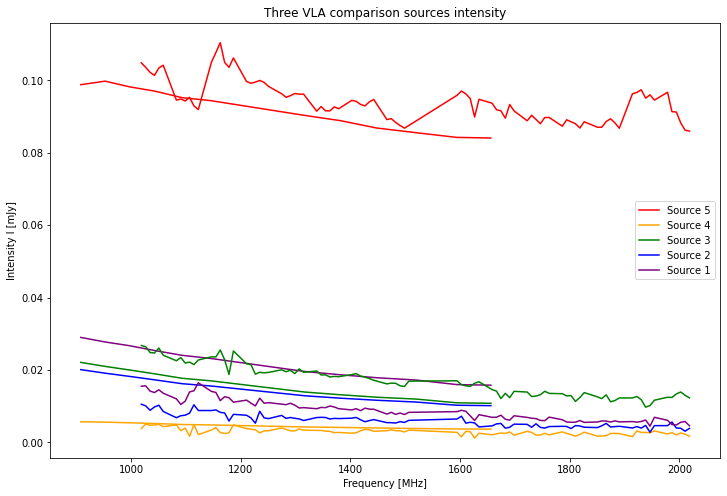

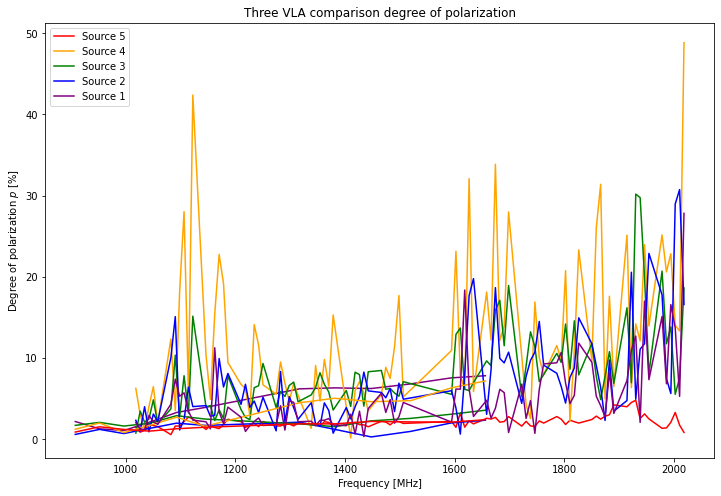

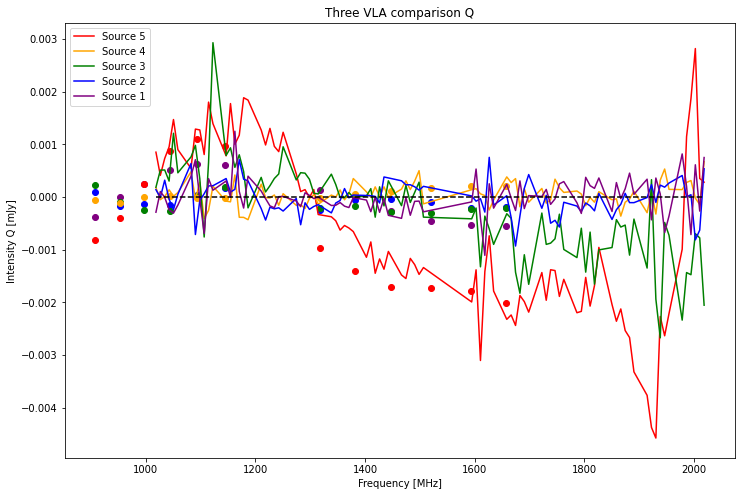

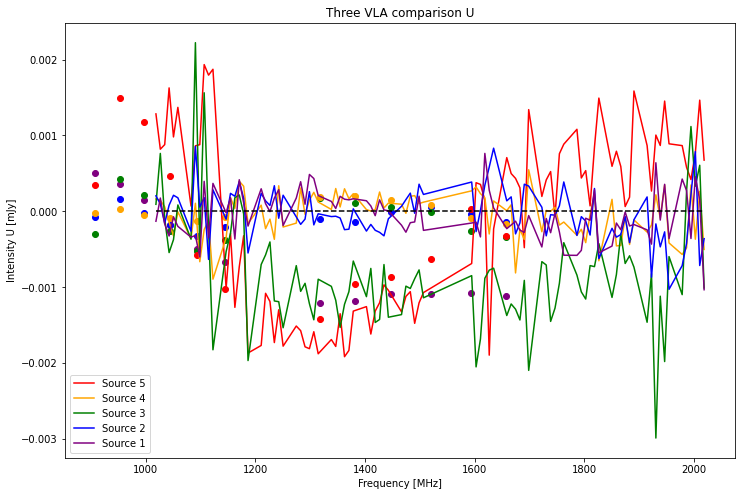

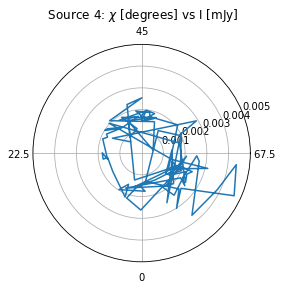

In [231]:
Pol_Angles_VLA = 0.5*np.arctan(U_phot_table_VLA/Q_phot_table_VLA)
Linpol_VLA = np.sqrt(U_phot_table_VLA**2 + Q_phot_table_VLA**2)
Labels_VLA = ['Source 5', 'Source 4', 'Source 3', 'Source 2', 'Source 1']

color_palette = ['r','orange','g','b','purple']

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison sources intensity')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, I_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.plot(freqs_middle/1e6, I_phot_table_compar[:,n], color=color_palette[4-n])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison degree of polarization')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, 100*Linpol_VLA[:,n]/I_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.plot(freqs_middle/1e6, 100*Linpol_compar[:,n]/I_phot_table_compar[:,n], color=color_palette[4-n])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison Q')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, Q_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.scatter(freqs_middle/1e6, Q_phot_table_compar[:,n], color=color_palette[4-n])
plt.hlines(0, min(Freqs_VLA)/1e6, max(Freqs_VLA)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
#plt.xlim(min(Freqs_VLA), max(freqs_upper))
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison U')
for n in range(5):
    plt.plot(Freqs_VLA/1e6, U_phot_table_VLA[:,n], label=Labels_VLA[n], color=color_palette[n])
    plt.scatter(freqs_middle/1e6, U_phot_table_compar[:,n], color=color_palette[4-n])
plt.hlines(0, min(Freqs_VLA)/1e6, max(Freqs_VLA)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_VLA[:,0], Linpol_VLA[:,0])
ax.set_rmax(0.005)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 4: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [256]:
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

I_hist_VLA = np.zeros((12,5))
Q_hist_VLA = np.zeros((12,5))
U_hist_VLA = np.zeros((12,5))

for n in range(5):
    I_hist_VLA_1, bin_edges_VLA_1, binnumber_VLA_1 = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    I_hist_VLA_2, bin_edges_VLA_2, binnumber_VLA_2 = stats.binned_statistic(Freqs_VLA, I_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    I_hist_VLA[:,n] = np.append(I_hist_VLA_1, I_hist_VLA_2)

    Q_hist_VLA_1, bin_edges_VLA_1, binnumber_VLA_1 = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    Q_hist_VLA_2, bin_edges_VLA_2, binnumber_VLA_2 = stats.binned_statistic(Freqs_VLA, Q_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    Q_hist_VLA[:,n] = np.append(Q_hist_VLA_1, Q_hist_VLA_2)

    U_hist_VLA_1, bin_edges_VLA_1, binnumber_VLA_1 = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_1)
    U_hist_VLA_2, bin_edges_VLA_2, binnumber_VLA_2 = stats.binned_statistic(Freqs_VLA, U_phot_table_VLA[:,n], statistic='mean', bins=bins_VLA_2)
    U_hist_VLA[:,n] = np.append(U_hist_VLA_1, U_hist_VLA_2)

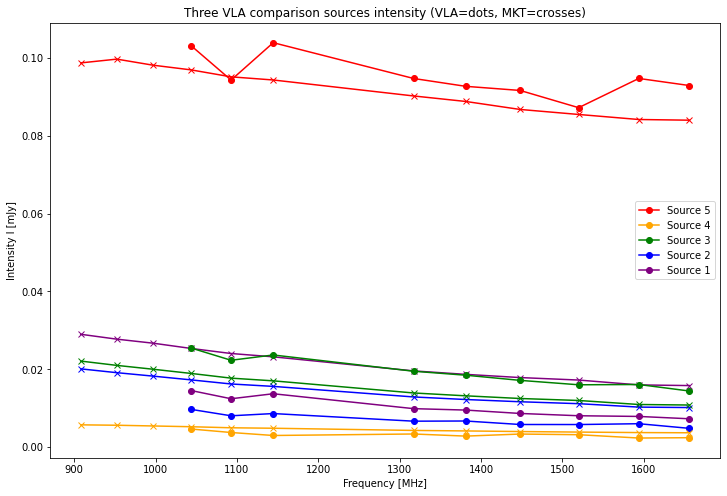

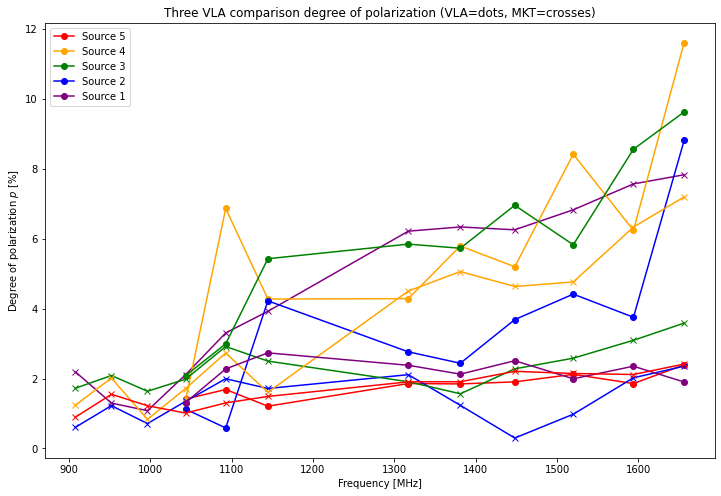

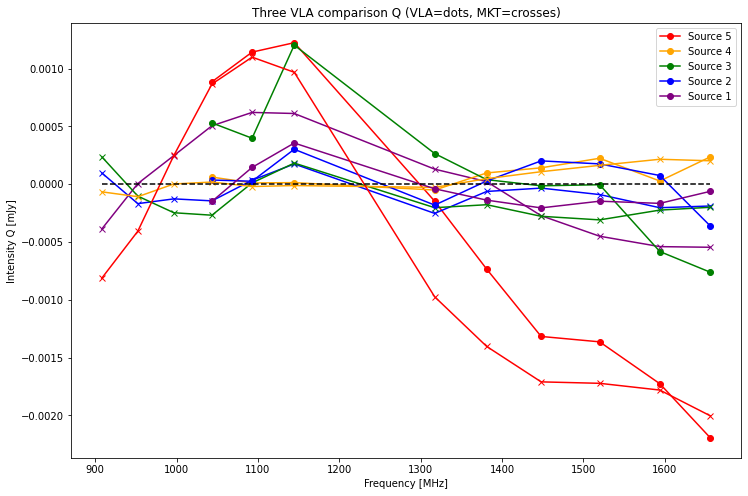

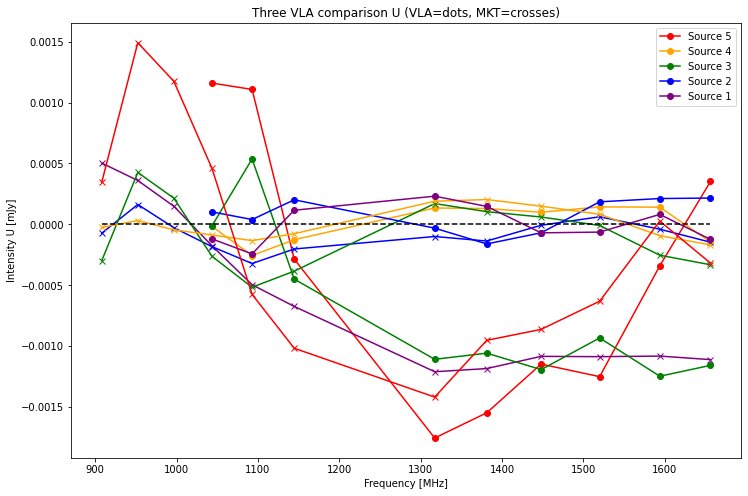

In [269]:
Pol_Angles_VLA_hist = 0.5*np.arctan(U_hist_VLA/Q_hist_VLA)
Linpol_VLA_hist = np.sqrt(U_hist_VLA**2 + Q_hist_VLA**2)

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison sources intensity (VLA=dots, MKT=crosses)')
for n in range(5):
    plt.plot(freqs_middle/1e6, I_hist_VLA[:,n], label=Labels_VLA[n], color=color_palette[n], marker='o')
    plt.plot(freqs_middle/1e6, I_phot_table_compar[:,n], color=color_palette[4-n], marker='x')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison degree of polarization (VLA=dots, MKT=crosses)')
for n in range(5):
    plt.plot(freqs_middle/1e6, 100*Linpol_VLA_hist[:,n]/I_hist_VLA[:,n], label=Labels_VLA[n], color=color_palette[n], marker='o')
    plt.plot(freqs_middle/1e6, 100*Linpol_compar[:,n]/I_phot_table_compar[:,n], color=color_palette[4-n], marker='x')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison Q (VLA=dots, MKT=crosses)')
for n in range(5):
    plt.plot(freqs_middle/1e6, Q_hist_VLA[:,n], label=Labels_VLA[n], color=color_palette[n], marker='o')
    plt.plot(freqs_middle/1e6, Q_phot_table_compar[:,n], color=color_palette[4-n], marker='x')
plt.hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
#plt.xlim(min(Freqs_VLA), max(freqs_upper))
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Three VLA comparison U (VLA=dots, MKT=crosses)')
for n in range(5):
    plt.plot(freqs_middle/1e6, U_hist_VLA[:,n], label=Labels_VLA[n], color=color_palette[n], marker='o')
    plt.plot(freqs_middle/1e6, U_phot_table_compar[:,n], color=color_palette[4-n], marker='x')
plt.hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
#plt.xlim(min(Freqs_VLA)/1e6, max(freqs_upper)/1e6)
plt.legend()
plt.show()

In [208]:
for n in range(90):
    dir = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\VLA_Data'
    fname_pt1 = r'G115.16-72.09_'+(4-len(str(n)))*'0'+str(n)
    fname_pt2 = r'-image.pbcor.smoothed.fits'
    Q_hdu = fits.open(get_pkg_data_filename(dir+ '\stokes_q\\' + fname_pt1+r'-Q'+fname_pt2))
    Q_plane = Q_hdu[0].data[0][0]
    U_hdu = fits.open(get_pkg_data_filename(dir+ '\stokes_u\\' + fname_pt1+r'-U'+fname_pt2))
    U_plane = U_hdu[0].data[0][0]
    Q_wcs_VLA = WCS(Q_hdu[0].header)
    U_wcs_VLA = WCS(U_hdu[0].header)
    Q_hdu.close()
    U_hdu.close()
    print(n)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [209]:
sky = w.pixel_to_world(30, 40)

print(Q_wcs_VLA)

plt.figure(figsize=(12,8))
plt.subplot(projection=Q_wcs_VLA, slices=('x', 'y', 0, 0))
plt.imshow(Q_plane, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
#apertures_compar.plot(color='red', lw=1)
plt.show()

NameError: name 'w' is not defined